# 编程作业2  logistic_regression（逻辑回归）

推荐运行环境：python 3.6 
建立一个逻辑回归模型来预测一个学生是否被大学录取。根据两次考试的结果来决定每个申请人的录取机会。有以前的申请人的历史数据，
可以用它作为逻辑回归的训练集
python实现逻辑回归
目标：建立分类器（求解出三个参数 θ0 θ1 θ2）即得出分界线
备注:θ1对应'Exam 1'成绩,θ2对应'Exam 2'
设定阈值，根据阈值判断录取结果
备注:阈值指的是最终得到的概率值.将概率值转化成一个类别.一般是＞0.5是被录取了,＜0.5未被录取.
实现内容：

sigmoid : 映射到概率的函数
model : 返回预测结果值
cost : 根据参数计算损失
gradient : 计算每个参数的梯度方向
descent : 进行参数更新
accuracy: 计算精度


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') #样式美化
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report#这个包是评价报告

# 准备数据

In [2]:
data = pd.read_csv('ex2data1.txt',names = ['exam1', 'exam2', 'admitted'])
data.head() #看前五行

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


##Error case1 TypeError:unhashable type :_ColorPalette  
运行问题更换方案sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2),color_codes=False) 因为自定义了画板颜色

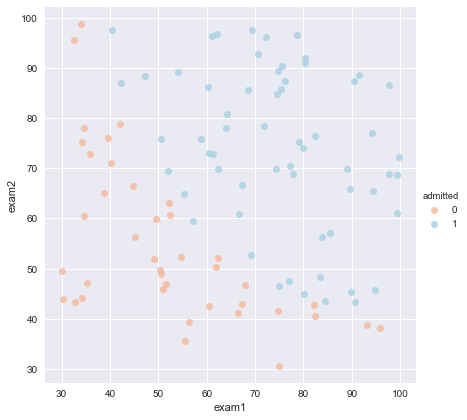

In [4]:
sns.set(context = "notebook",style = "darkgrid",palette = sns.color_palette("RdBu",2)) #设置样式参数,默认主题 darkgrid（灰色背景+白网格）,调色板 2色
sns.lmplot('exam1','exam2',hue = 'admitted',data = data, #hue参数是将name所指定的不同类型的数据叠加在一张图中显示
          size = 6,
          fit_reg =False,   #fit_reg'参数，控制是否显示拟合的直线
          scatter_kws = {"s":50})
plt.show()

In [5]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并 axis = 1的时候，concat就是行对齐，然后将不同列名称的两张表合并 加列
    return data.iloc[:, :-1].values  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放在逻辑回归同样适用

In [6]:
X = get_X(data)
print(X.shape)
y = get_y(data)
print(y.shape)

(100, 3)
(100,)


# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))# your code here  (appro ~ 1 lines)

下面程序会调用上面你写好的函数，并画出sigmoid函数图像。如果你的程序正确，你应该能在下方看到函数图像。

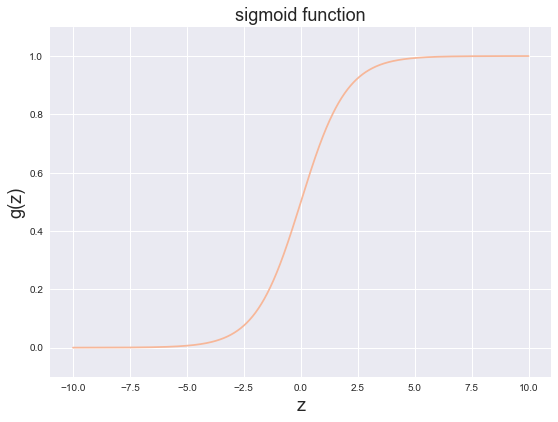

In [8]:
fig,ax = plt.subplots(figsize = (8,6))
ax.plot(np.arange(-10,10,step = 0.01),
          sigmoid(np.arange(-10,10,step = 0.01)))
ax.set_ylim((-0.1,1.1))  #lim 轴线显示长度
ax.set_xlabel('z',fontsize=18)
ax.set_ylabel('g(z)',fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$

In [9]:
theta = np.zeros(3) # X(m*n) so theta is n*1
theta

array([0., 0., 0.])

In [10]:
def cost(theta,X,y):
    ''' cost fn is -l(theta) for you to minimize'''
    # your code here  (appro ~ 2 lines)
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))
# Hint:X @ theta与X.dot(theta)等价

In [11]:
cost(theta, X, y)

0.6931471805599453

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [12]:
def gradient(theta,X,y):
    # your code here  (appro ~ 2 lines)
    return (1/len(X)) *X.T@(sigmoid(X@theta)-y)
#  return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [13]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数
> * 这里我使用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去寻找参数  

In [14]:
import scipy.optimize as opt

In [15]:
res =opt.minimize(fun = cost,x0 = theta,args = (X,y), method='Newton-CG', jac=gradient)

##Error case4 The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()  Numpy对逻辑表达式判别不清楚， any表示只要有一个True 就返回 True,all表示所有元素为True才会返回True, 否则返回False.

In [16]:
print(res)

     fun: 0.20349770159082373
     jac: array([-1.11232496e-05, -7.41503794e-04, -6.38123690e-04])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 29
    njev: 253
  status: 0
 success: True
       x: array([-25.16143003,   0.20623248,   0.20147238])


# 用训练集预测和验证

In [17]:
def predict(x, theta):
    # your code here  (appro ~ 2 lines)
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)   #实现变量类型转换

In [18]:
final_theta = res.x
y_pred = predict(X,final_theta)
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [19]:
print(res.x)

[-25.16143003   0.20623248   0.20147238]


In [20]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[124.88773847  -1.02362658  -1.        ]


In [21]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


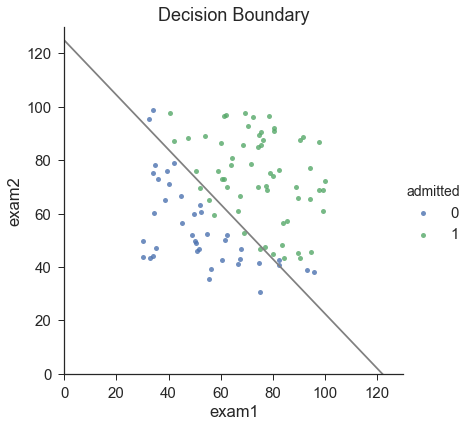

In [22]:
sns.set(context="notebook", style="ticks", font_scale=1.5) # 默认使用notebook上下文 主题 context可以设置输出图片的大小尺寸(scale)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130) 
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()